# Figures from models

In [1]:
import pystan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

az.style.use('arviz-darkgrid')

df = pd.read_csv('../data/raw/train.csv')

In [2]:
def z_std(x):
    """
    Centres at mean 0 and standard deviation 1
    """
    z_score = (x - x.mean()) / x.std()
    return(z_score)

df['log_sales_price'] = np.log(df['SalePrice'])
df['log_lot_area'] = np.log(df['LotArea'])

df['log_sales_price_z'] = z_std(df[['log_sales_price']])
df['log_lot_area_z'] = z_std(df[['log_lot_area']])

#df['log_sales_price_std'] = df['log_sales_price']/df['log_sales_price'].mean()

df['neighbourhood'] = df['Neighborhood'].astype('category').cat.codes+1

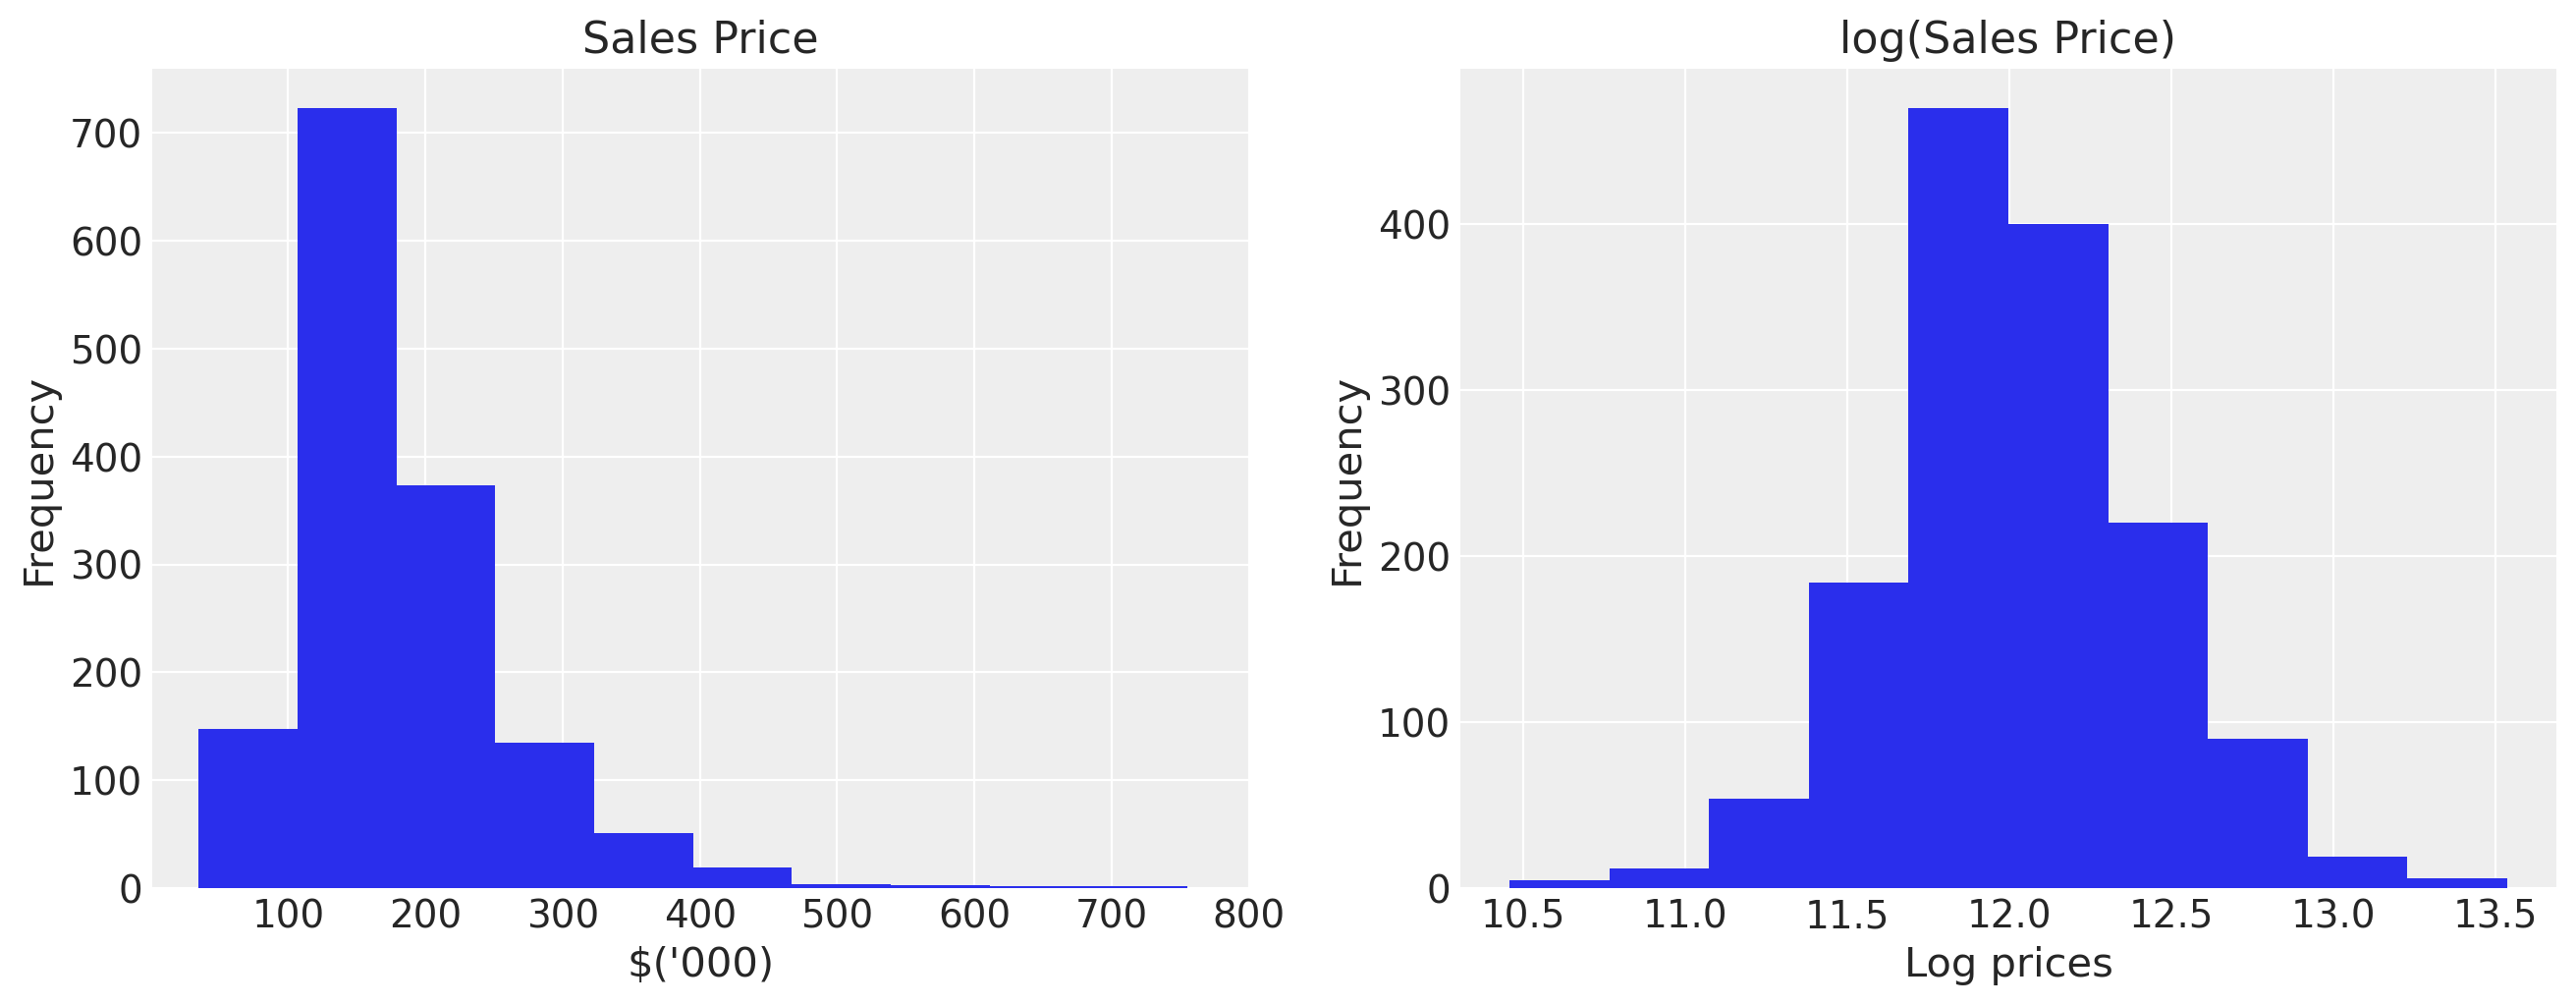

In [51]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize = (13, 5))
df['SalePrice'].plot.hist(title = 'Sales Price', ax = axes[0])
np.log(df['SalePrice']).plot.hist(title = 'log(Sales Price)', ax = axes[1])

# Adjust x axis on both plots
axes[0].set_xlim(1000, 800000)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(x/1000))))
axes[0].set_xlabel("$('000)")

axes[1].set_xlabel("Log prices")

plt.savefig('figures/1_histograms.svg', dpi=72)

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


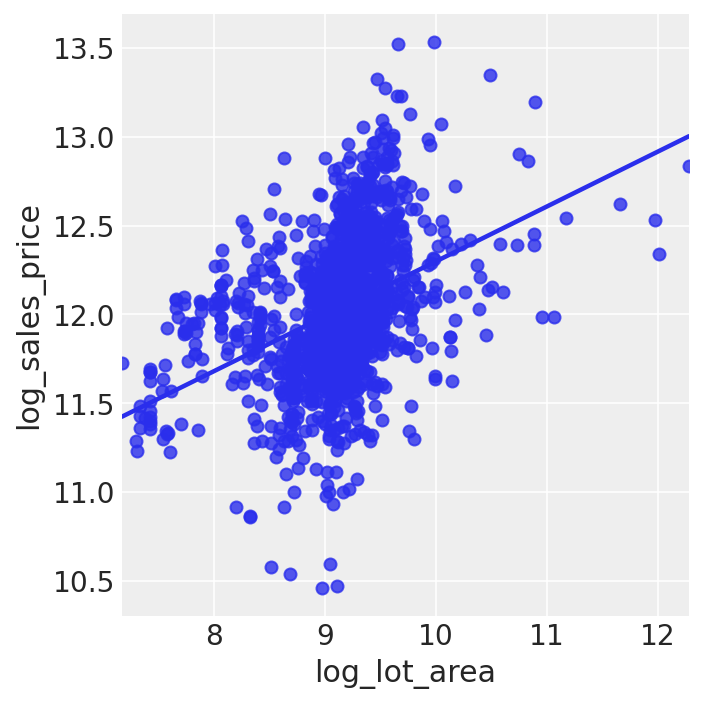

In [3]:
sns.lmplot(x='log_lot_area',y='log_sales_price',data=df,fit_reg=True, ci = False)
plt.tight_layout()

plt.savefig('figures/2_pooling_scatter.svg', dpi=72)

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


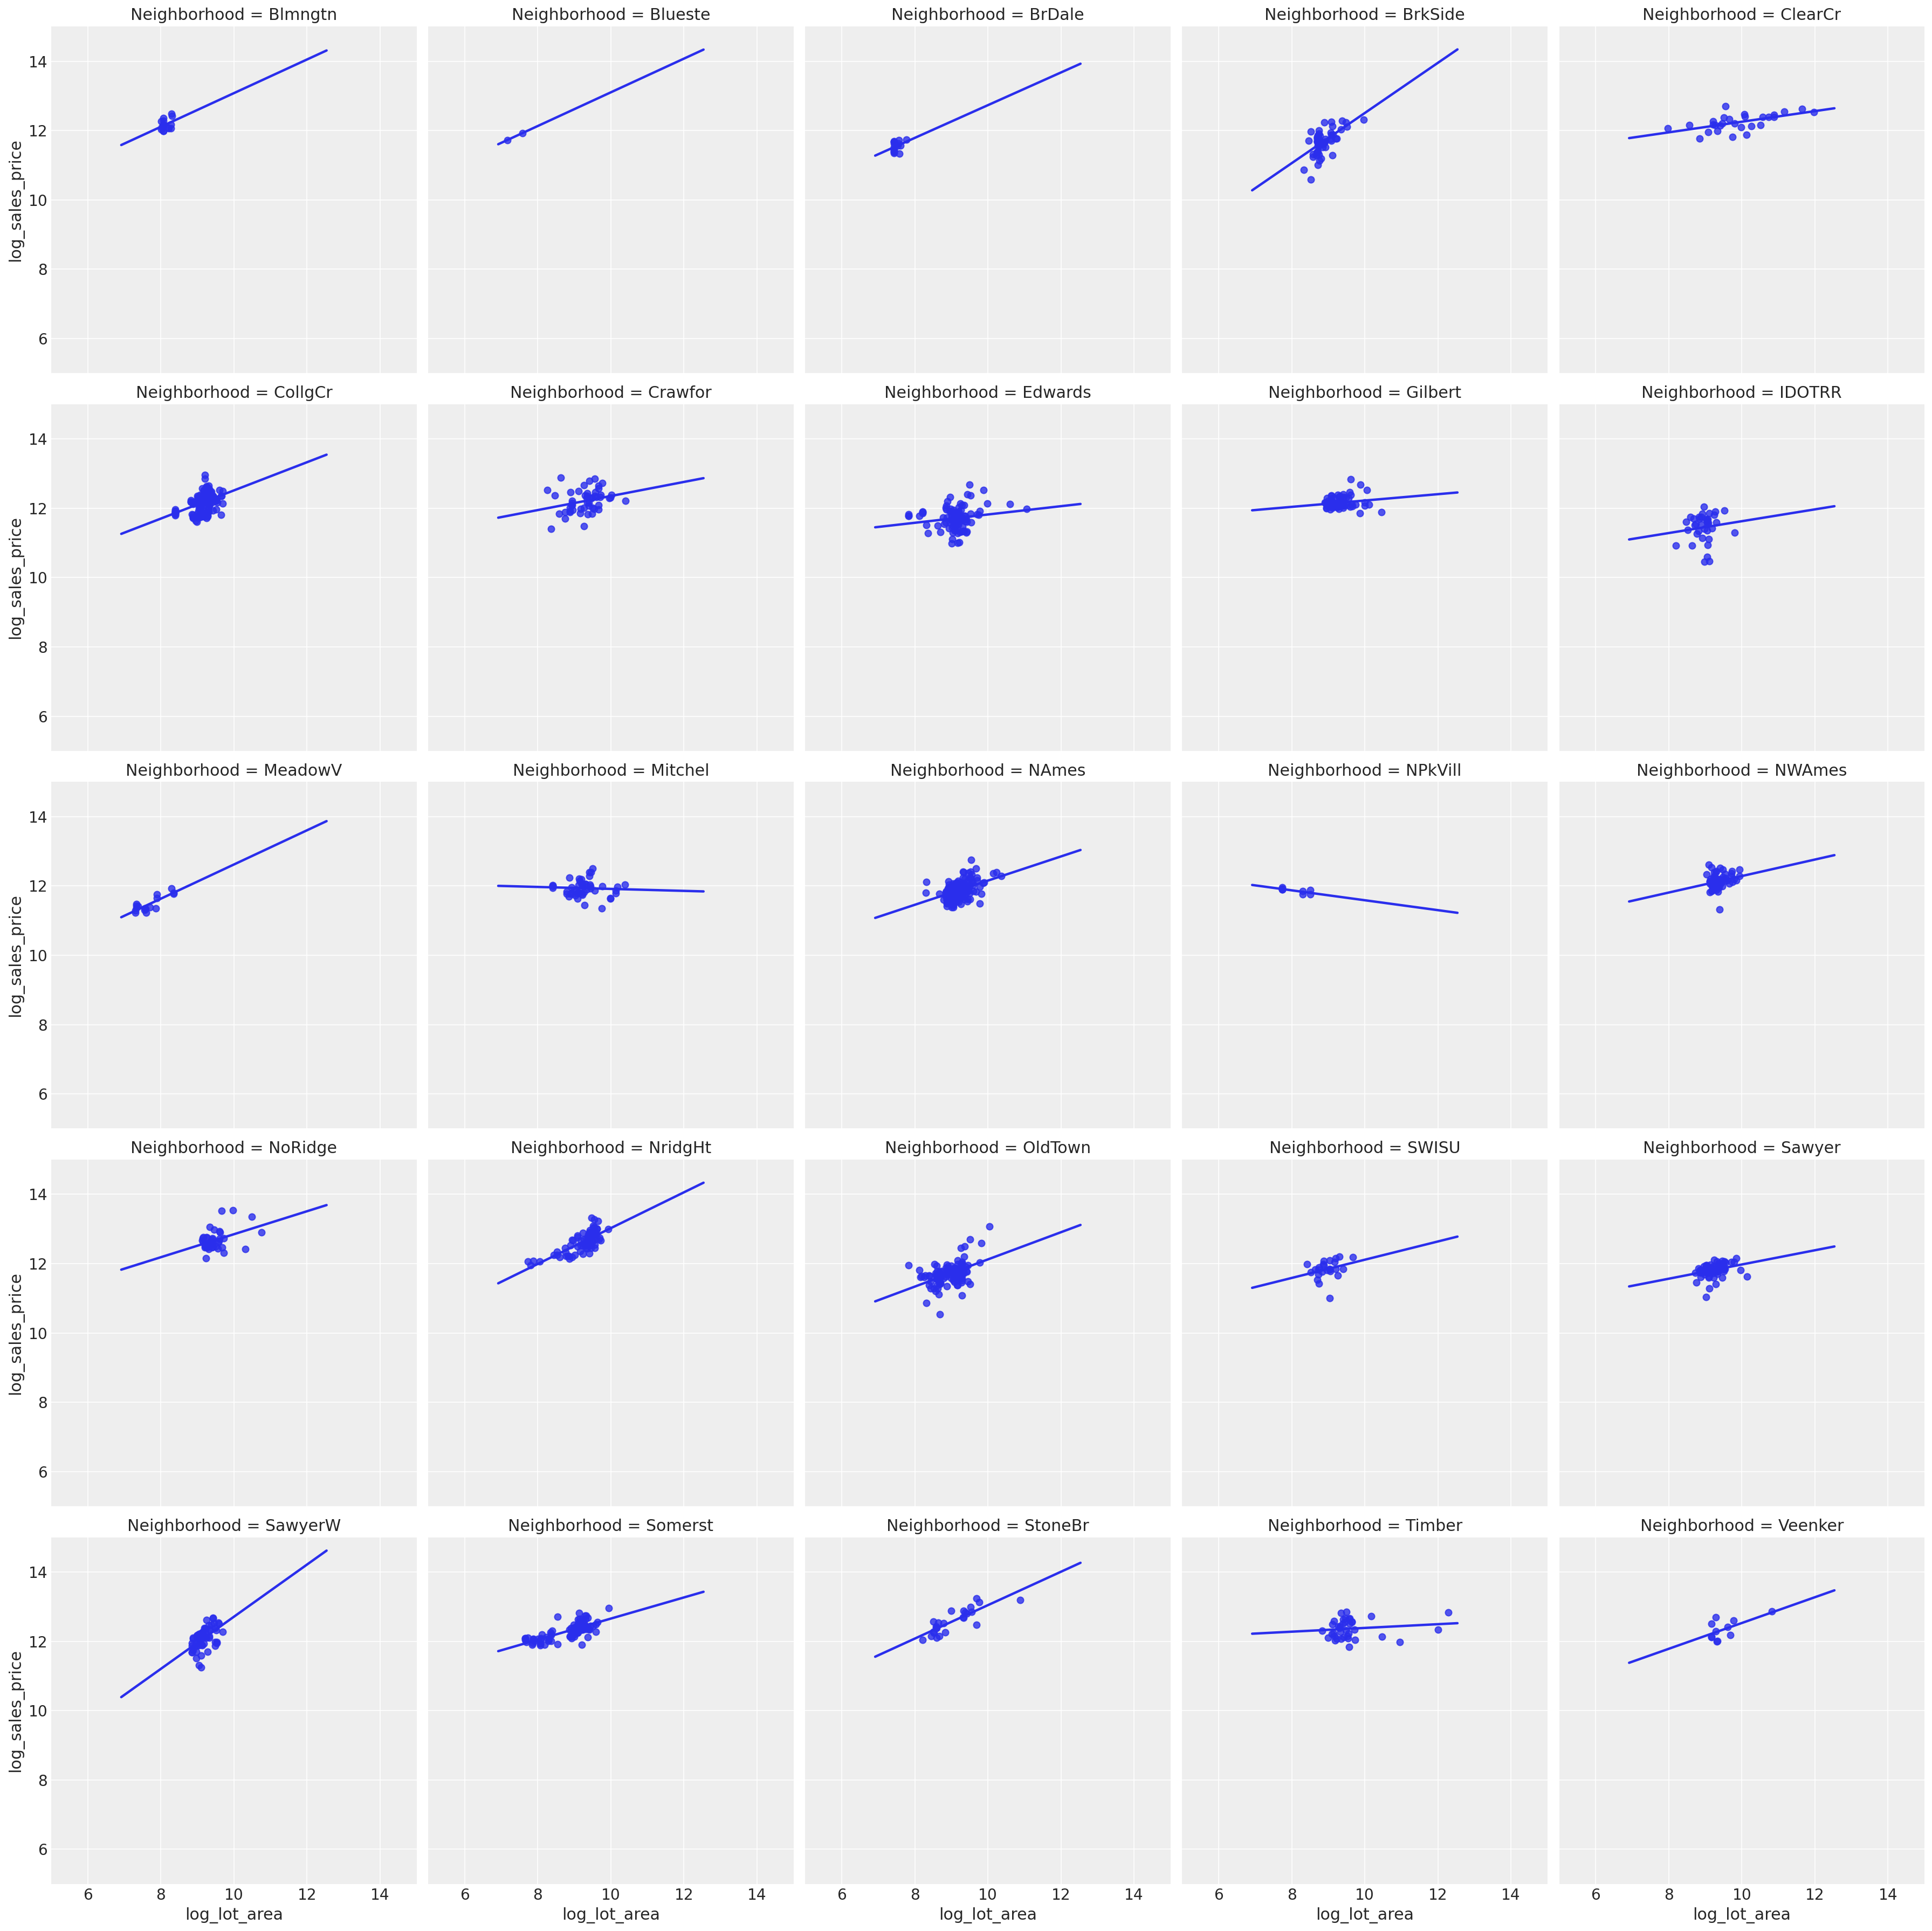

In [4]:
facet_scatter = sns.lmplot(x="log_lot_area", 
                           y="log_sales_price", 
                           col="Neighborhood",
                           col_wrap = 5,
                           data=df,
                           ci = None, 
                           truncate=False,
                           col_order = sorted(df['Neighborhood'].drop_duplicates()))

facet_scatter.set(xlim=(5, 15))
facet_scatter.set(ylim=(5, 15))
plt.tight_layout()

plt.savefig('figures/3_facet_scatter.svg', dpi=72)

In [5]:
no_pooling_model = pystan.StanModel(file = '../models/blog_code.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c850d56b2148f1d13a8bfb490e9a2b34 NOW.


In [6]:
npm_data_check = dict(N = len(df),
                      log_sales_price = df['log_sales_price_z'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['neighbourhood'].unique()),
                      alpha_sd = 1, 
                      beta_sd = 1, 
                      run_estimation = 0)

fit_npm_check = no_pooling_model.sampling(data=npm_data_check, seed = 12345)
npm_df_check = fit_npm_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


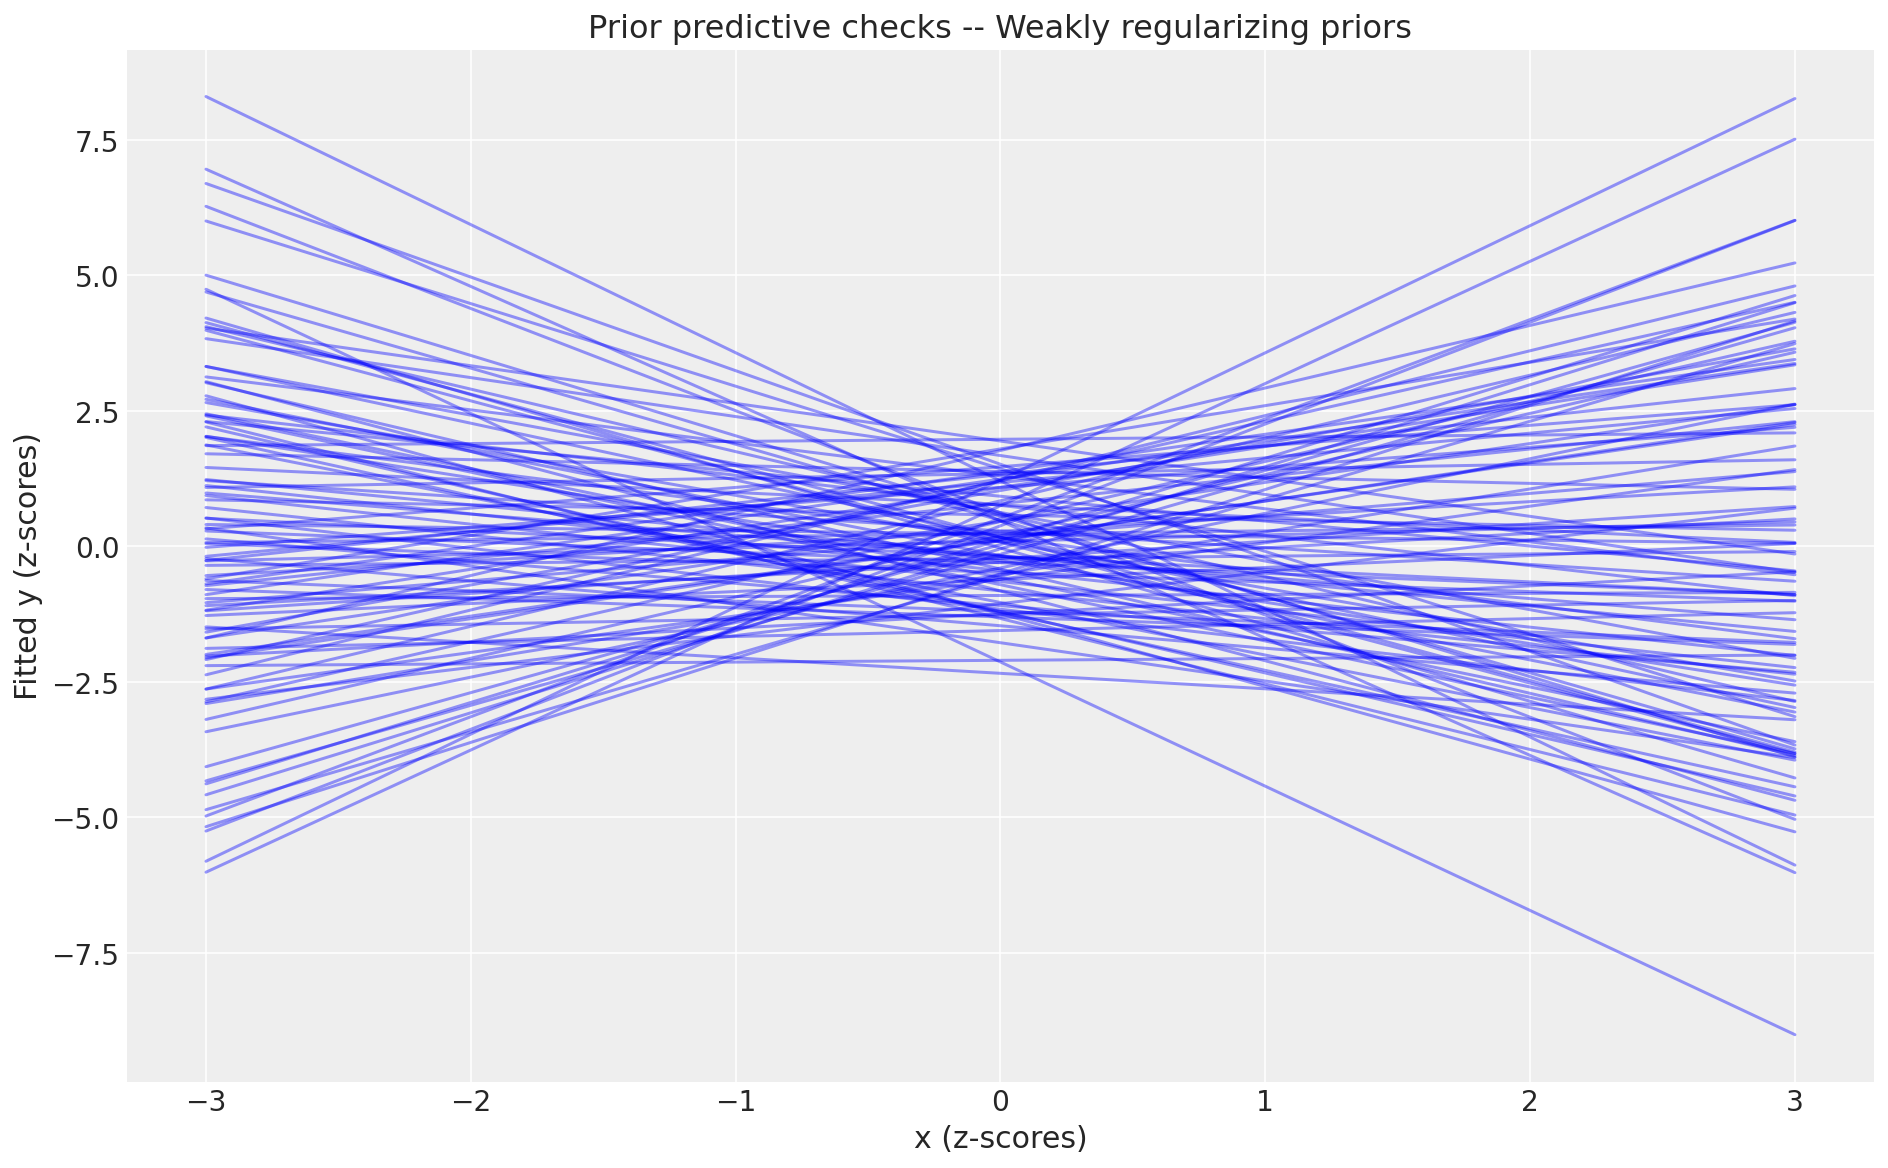

In [16]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, beta in zip(npm_df_check["alpha[4]"][:100], npm_df_check["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="blue", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors")
plt.savefig('figures/4_prior_predictive_check.svg', dpi=72);

In [58]:
#npm_check_az = az.from_pystan(
#    posterior=fit_npm_check,
#    posterior_predictive="y_hat",
#    observed_data="log_sales_price",
#    log_likelihood='log_lik',
#)
#
#
#az.plot_ppc(data = npm_check_az, 
#            kind = 'kde', 
#            data_pairs = {'log_sales_price' : 'y_hat'},
#            legend = False,
#            color='cyan',
#            mean = False,
#            figsize=(8, 5),
#            alpha = 0.5,
#            num_pp_samples=200)
#
#plt.xlim(-4, 5)
#plt.legend(['Prior predictive simulations', 'Observed y'])
#plt.vlines(x=df['log_sales_price_std'].min(), ymin=0, ymax=13,color='black', linestyles='dashed')
#plt.vlines(x=df['log_sales_price_std'].max(), ymin=0, ymax=13,color='black', linestyles='dashed')
#plt.savefig('figures/4_prior_predictive_check.svg', dpi=72);

In [8]:
npm_data_check_wide = dict(N = len(df),
                      log_sales_price = df['log_sales_price_z'],
                      log_lot_area = df['log_lot_area_z'],
                      neighbourhood = df['neighbourhood'],
                      N_neighbourhood = len(df['Neighborhood'].unique()),
                      alpha_sd = 10, 
                      beta_sd = 10, 
                      run_estimation = 0)

fit_npm_check_wide = no_pooling_model.sampling(data=npm_data_check_wide, seed = 12345)
npm_df_check_wide = fit_npm_check_wide.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


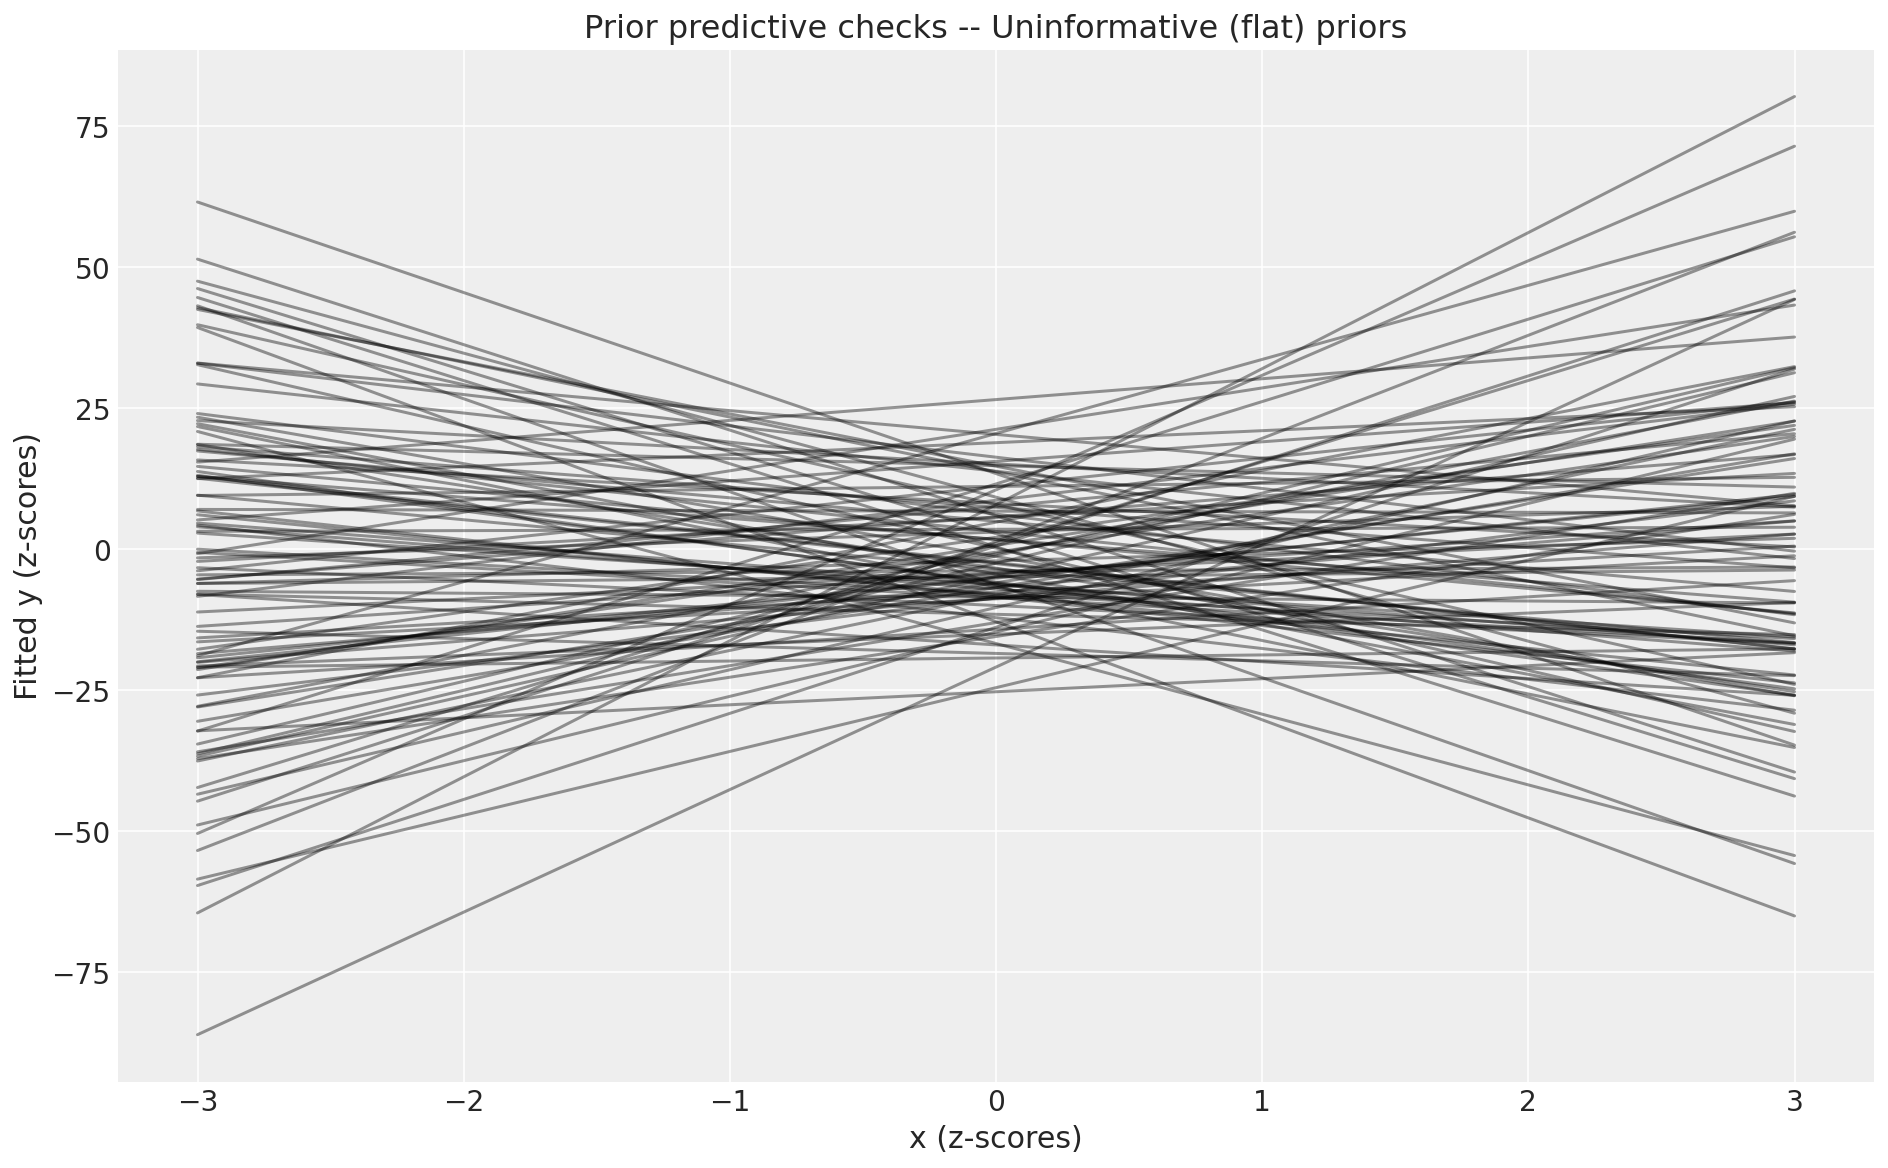

In [15]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha_wide, beta_wide in zip(npm_df_check_wide["alpha[4]"][:100], npm_df_check_wide["beta"][:100]):
    y_wide = alpha_wide + beta_wide * x
    ax.plot(x, y_wide, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Uninformative (flat) priors")
plt.savefig('figures/5_prior_predictive_check_wide.svg', dpi=72);

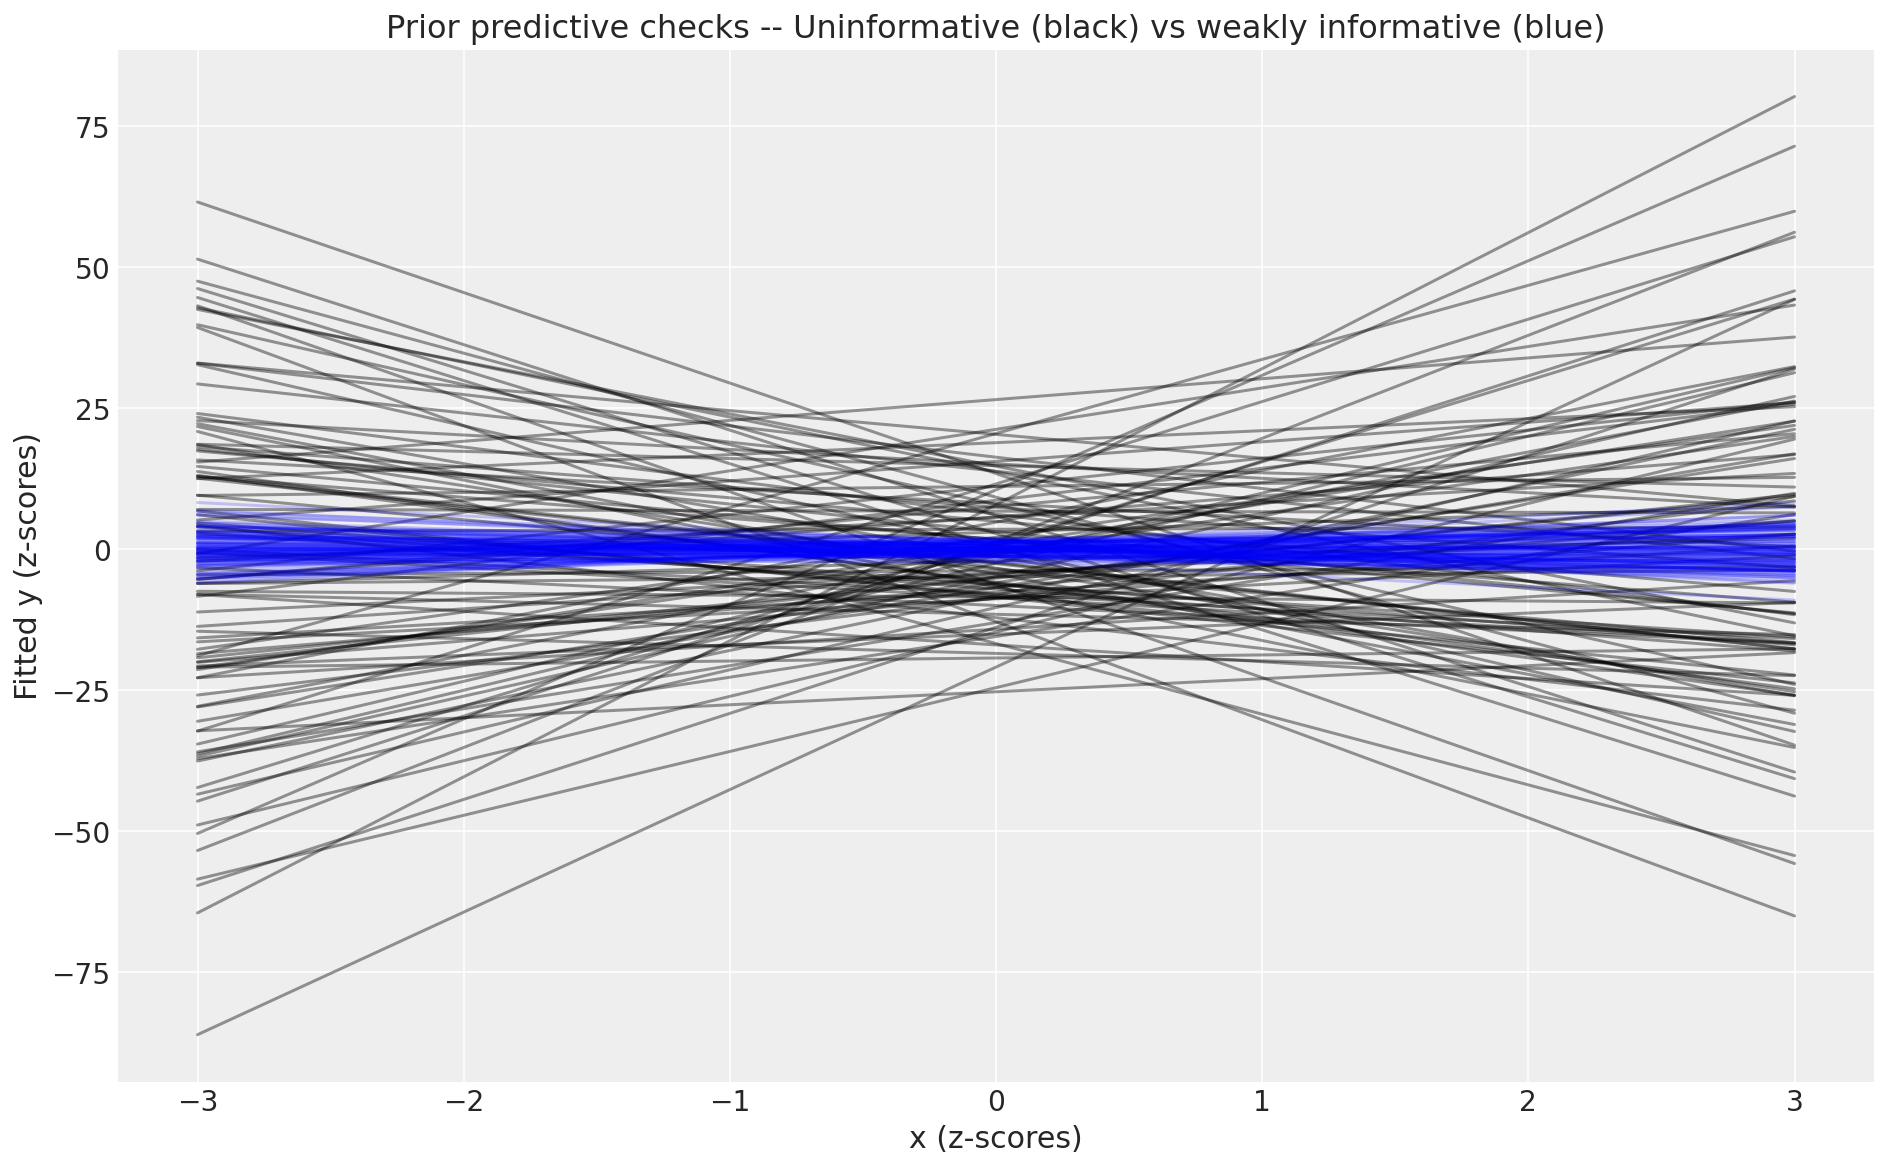

In [13]:
# Putting both on the same scale
_, ax = plt.subplots(figsize = (13, 8))

for alpha_wide, beta_wide in zip(npm_df_check_wide["alpha[4]"][:100], npm_df_check_wide["beta"][:100]):
    y_wide = alpha_wide + beta_wide * x
    ax.plot(x, y_wide, c="k", alpha=0.4)
    
for alpha, beta in zip(npm_df_check["alpha[4]"][:100], npm_df_check["beta"][:100]):
    y = alpha + beta * x
    ax.plot(x, y, c="blue", alpha=0.2)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Uninformative (black) vs weakly informative (blue)")
plt.savefig('figures/5_prior_predictive_check_compare.svg', dpi=72);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


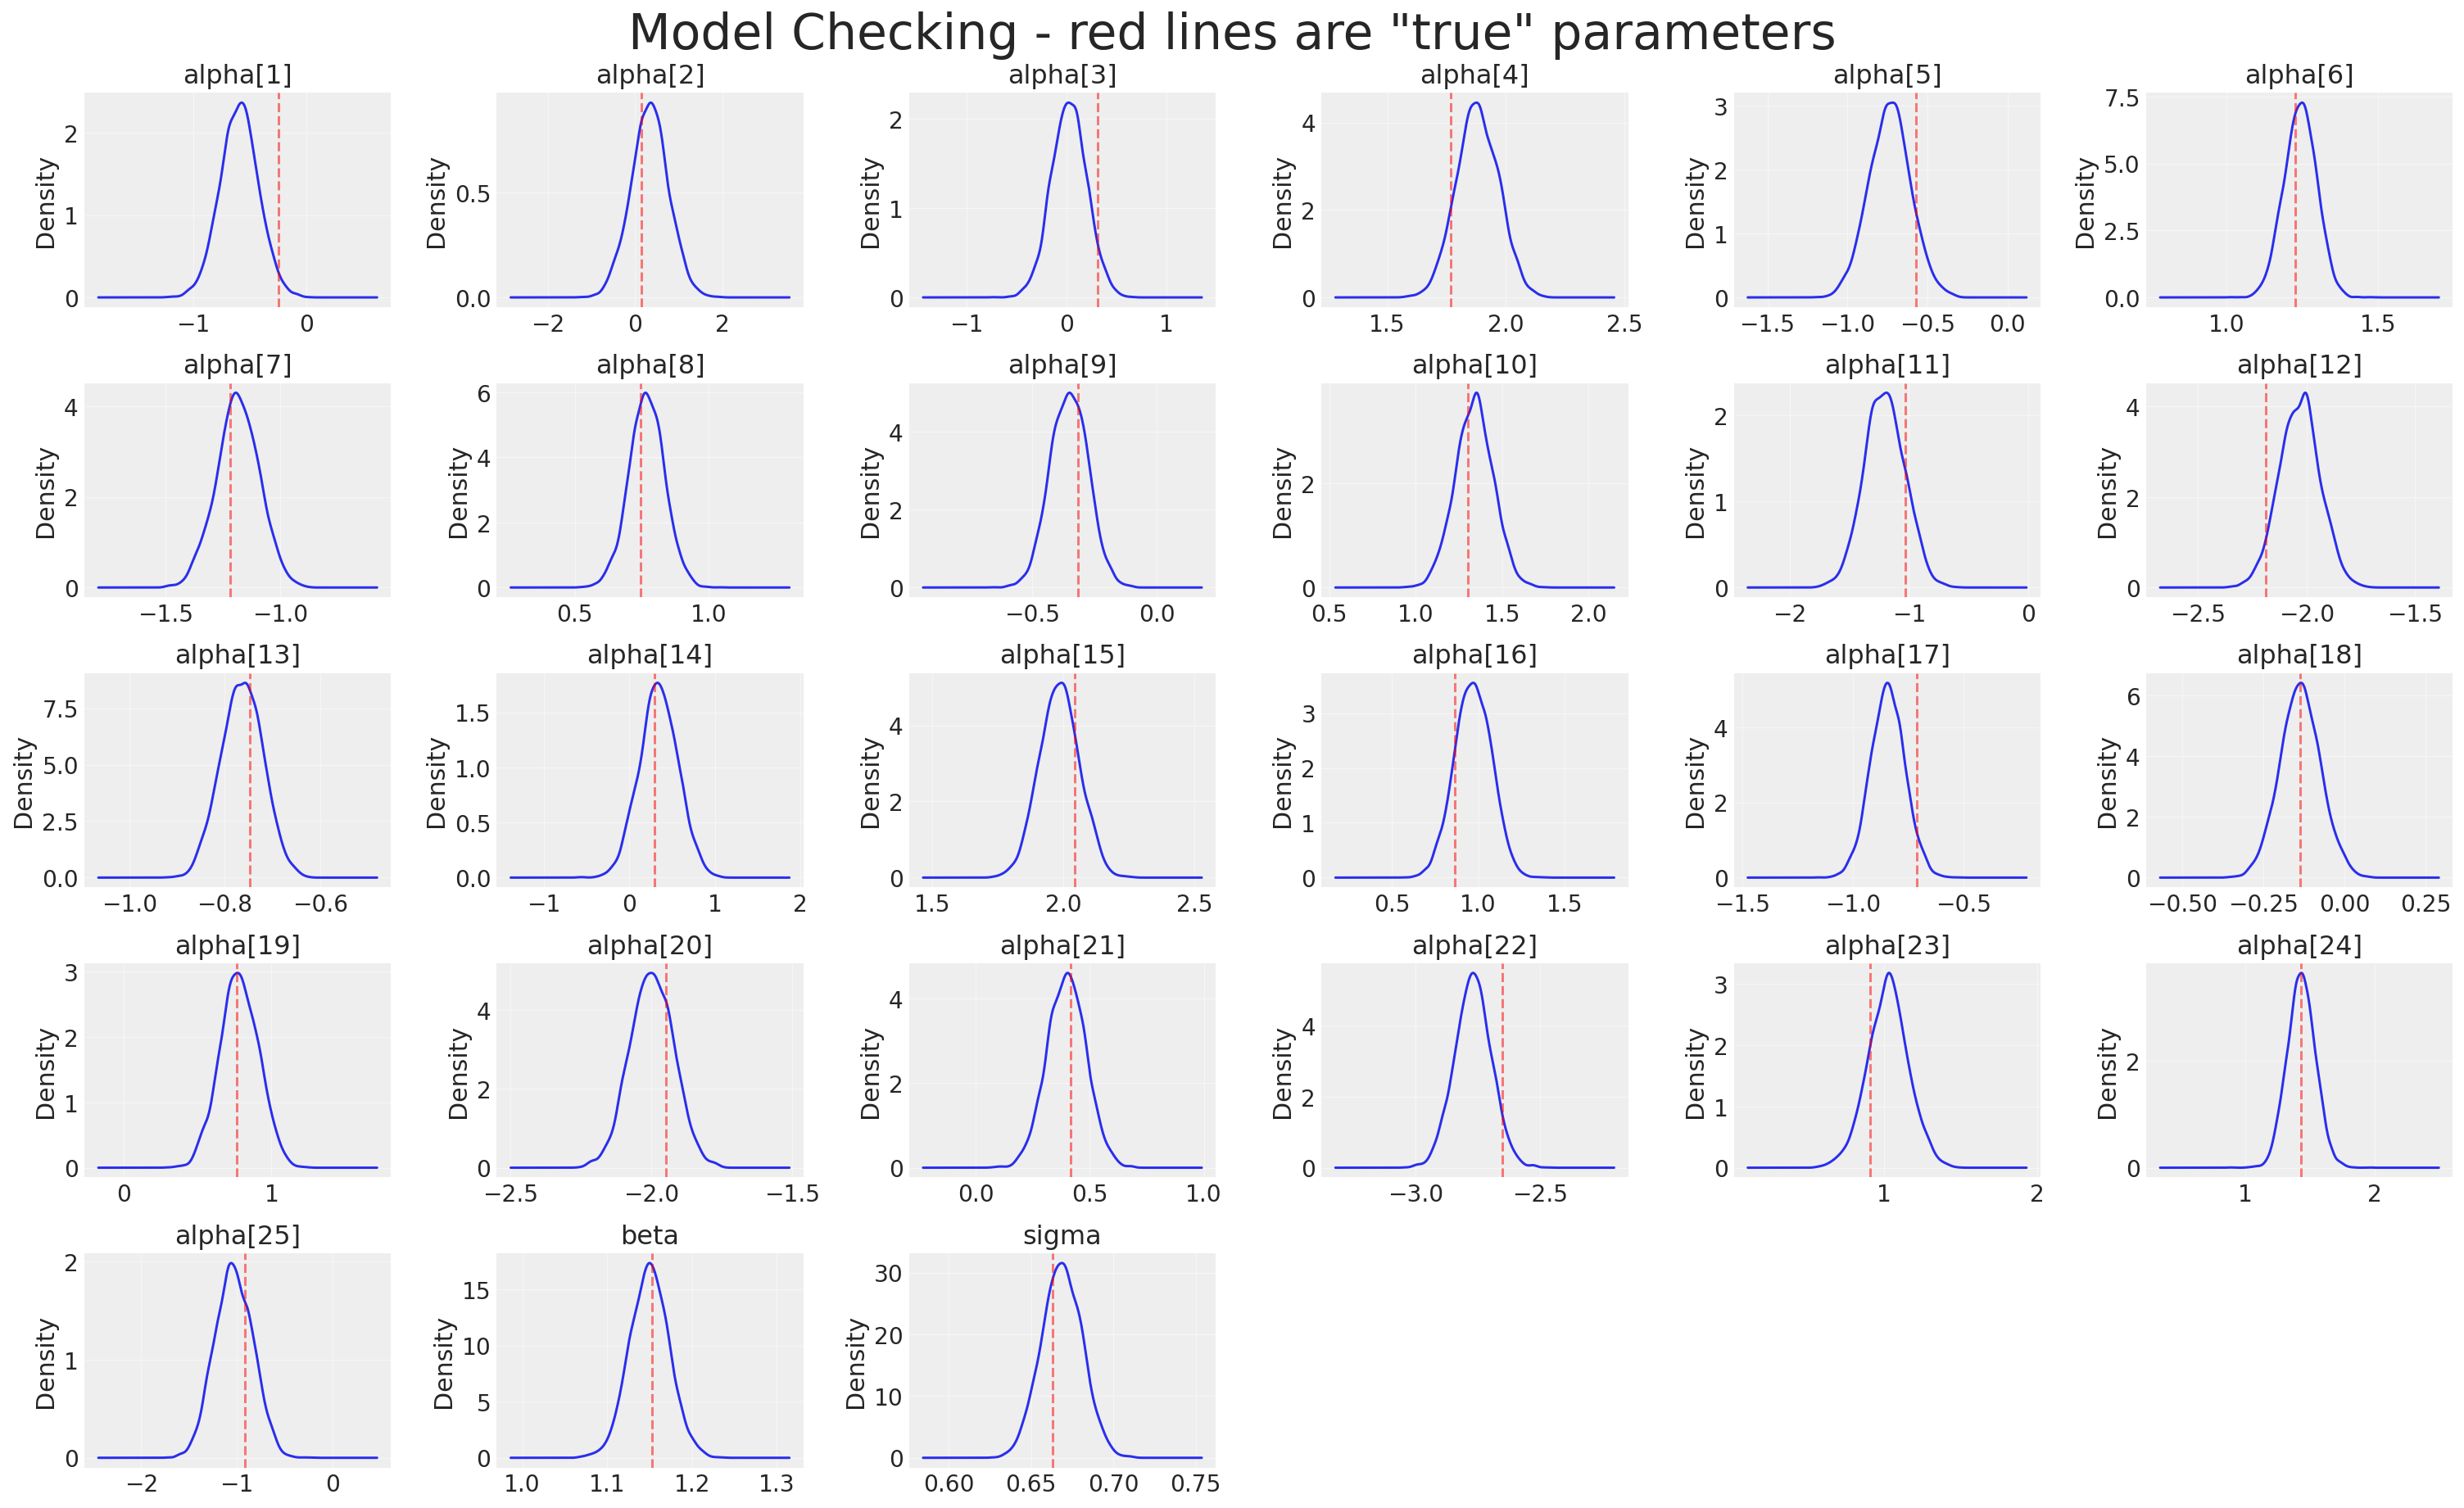

In [11]:
# Pick random simulation, let's say 10
random_draw = 50

# Extract the simulated (fake) data implied by the parameters in sample 10
y_sim = npm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]

# Extract the parameteres corresponding to sample 10
true_parameters = npm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

# Fit the model on the fake data
_npm_data_check = dict(N = len(df),
              log_sales_price = y_sim, # this is now fitting on the extracted fake data in sample 10
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

_fit_npm_check = no_pooling_model.sampling(data=_npm_data_check, seed = 12345)
_npm_df_check = _fit_npm_check.to_dataframe()
fake_fit = _npm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

# Plot will give distributions of all parameteres to see if it can capture the known parameters
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking - red lines are "true" parameters', size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df[['variable']].drop_duplicates().set_index('variable').index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()
plt.savefig('figures/6_fit_fake_data.svg', dpi=72);

In [144]:
npm_data = dict(N = len(df),
              log_sales_price = df['log_sales_price_z'],
              log_lot_area = df['log_lot_area_z'],
              neighbourhood = df['neighbourhood'],
              N_neighbourhood = len(df['Neighborhood'].unique()),
              alpha_sd = 1, 
              beta_sd = 1, 
              run_estimation = 1)

fit_npm = no_pooling_model.sampling(data=npm_data, seed = 12345)

npm_az = az.from_pystan(
    posterior=fit_npm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_npm_df = fit_npm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


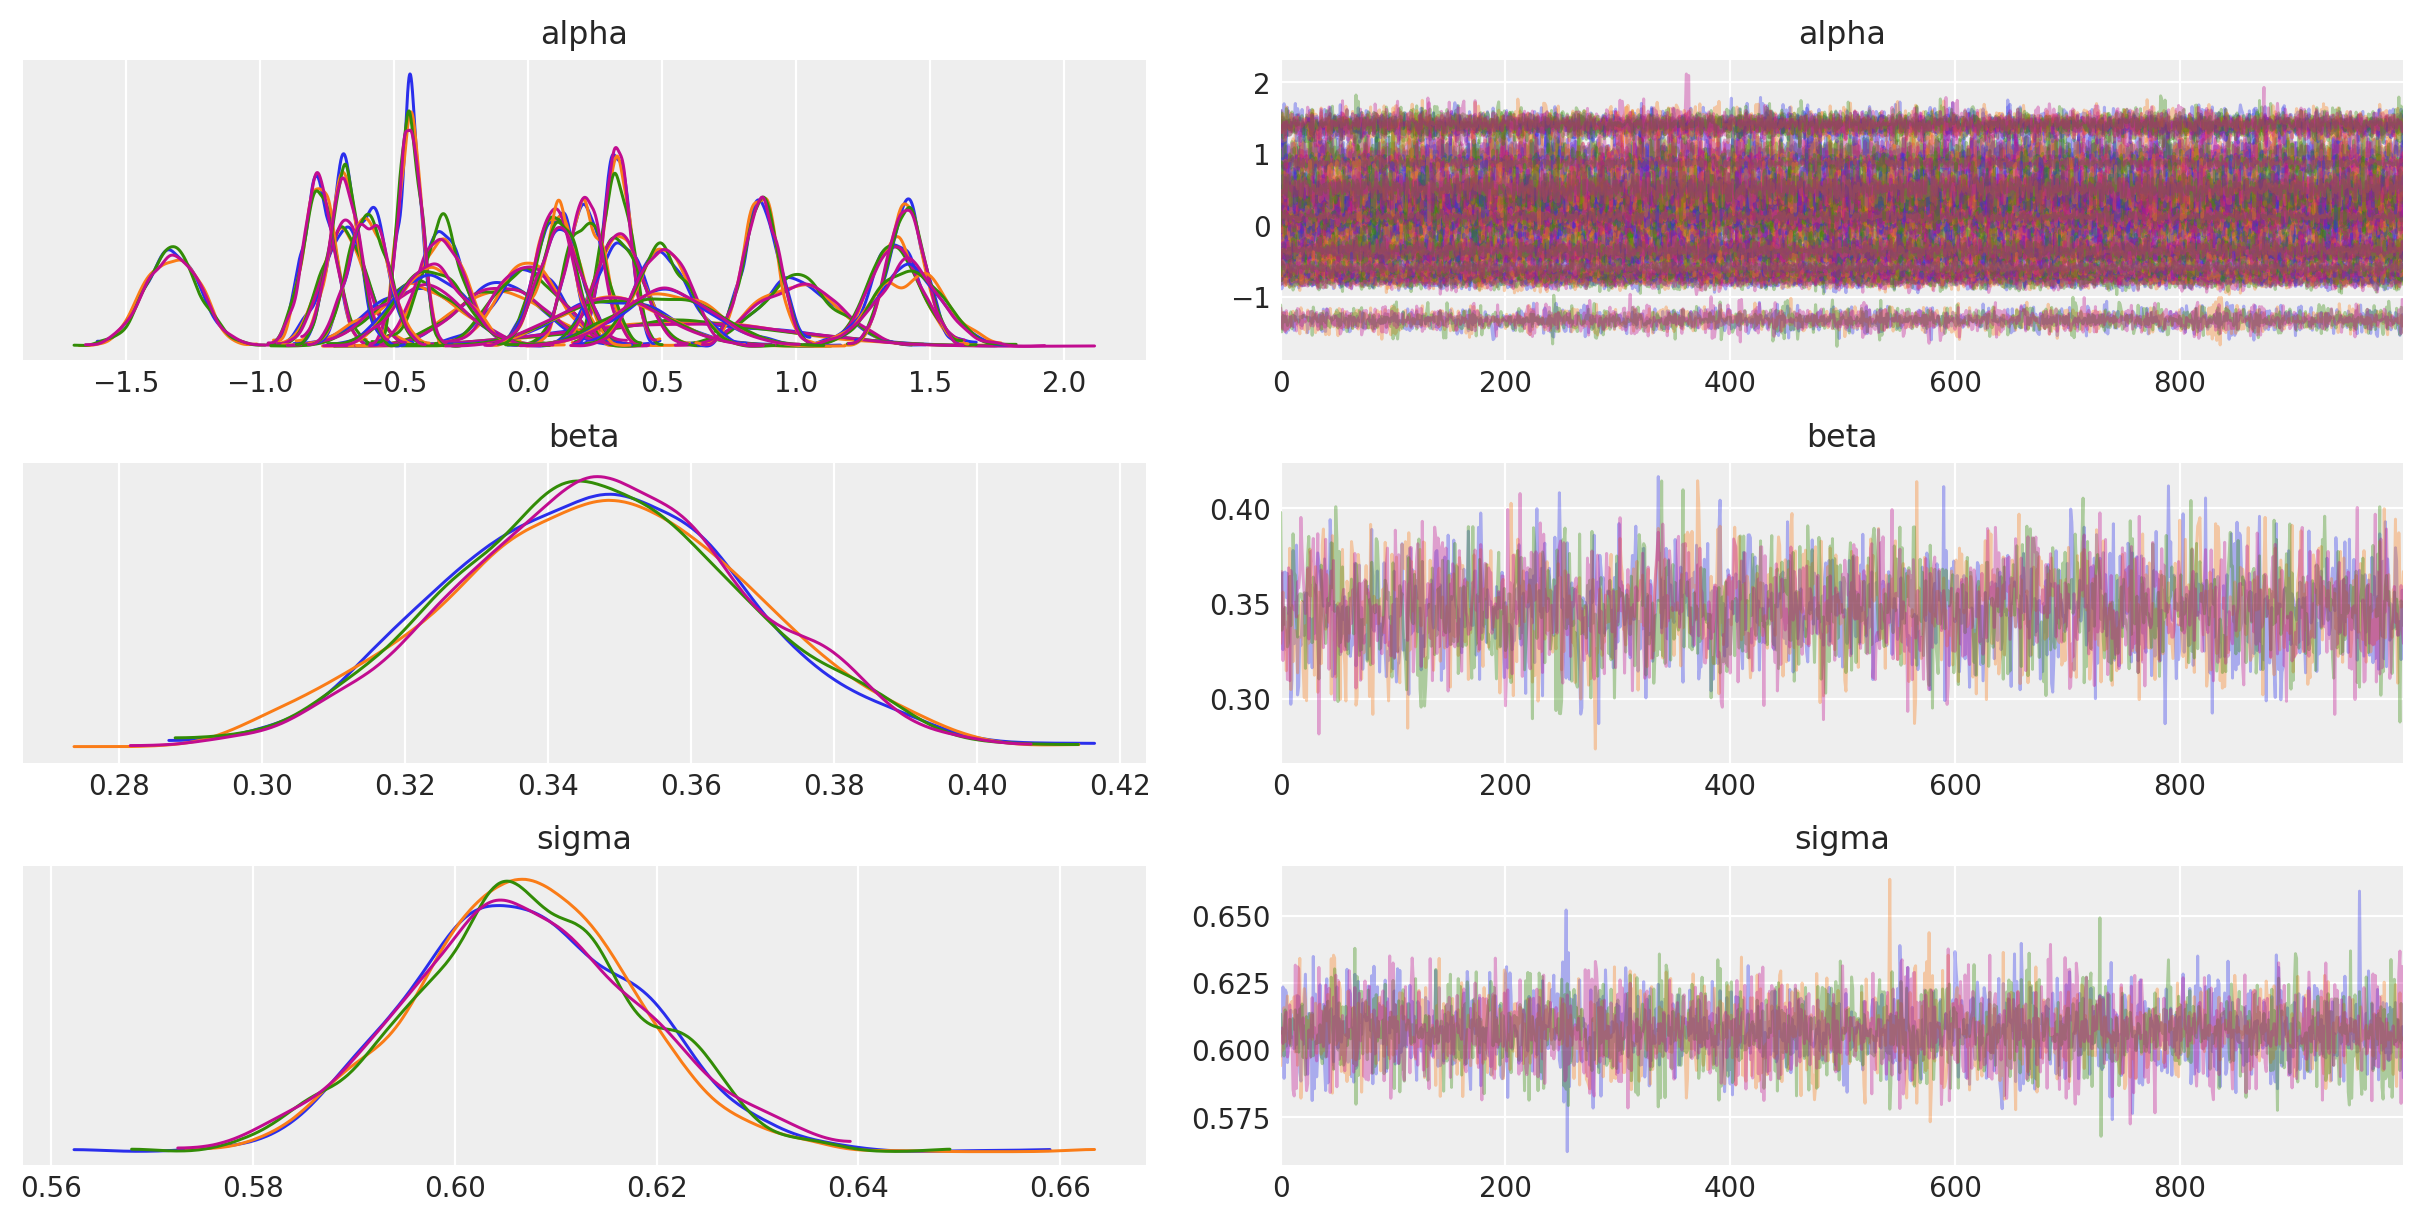

In [145]:
# Inspect model fit
az.plot_trace(fit_npm, 
              var_names=["alpha", "beta", "sigma"], 
              compact = True, 
              chain_prop = 'color')

plt.savefig('figures/7_trace_plot.png', dpi=72);

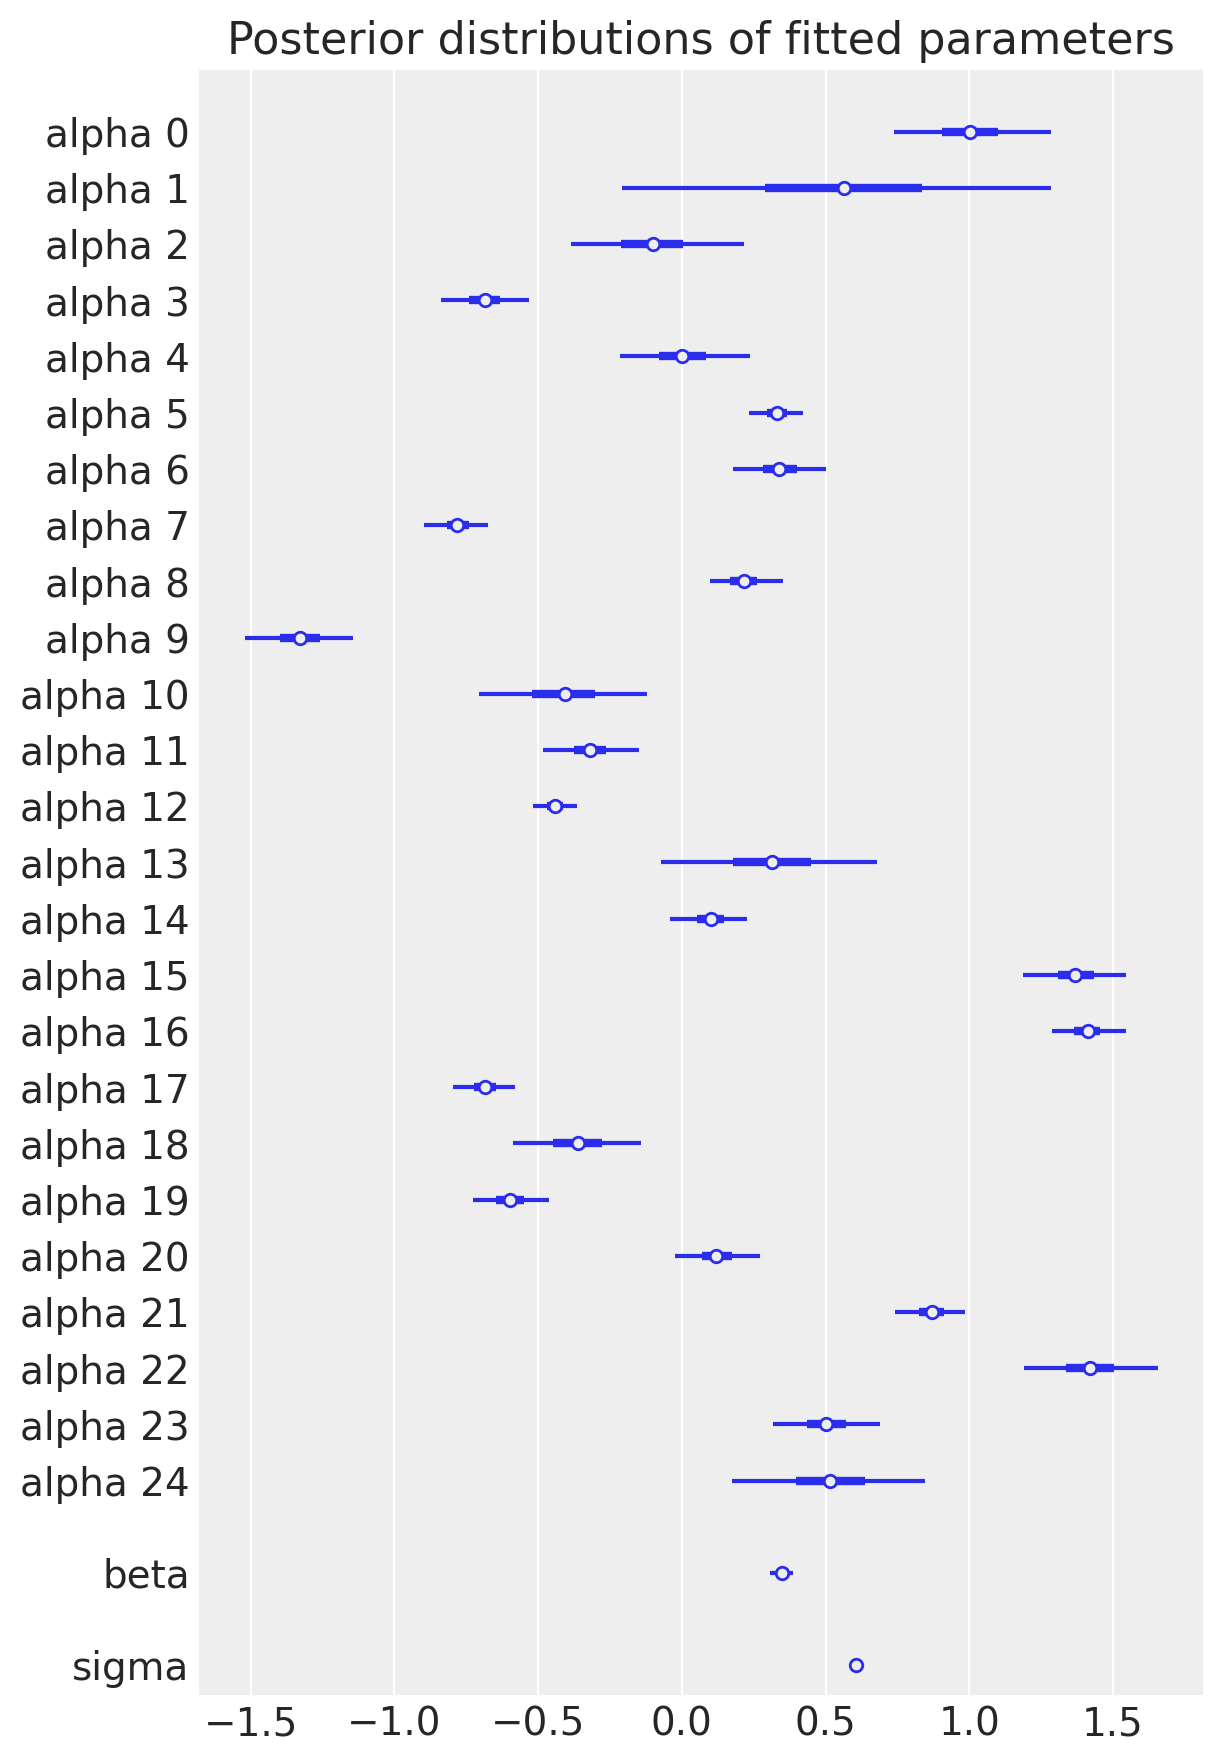

In [146]:
# Inspect model fit
axes = az.plot_forest(fit_npm, 
              var_names=["alpha", "beta", "sigma"],
              combined = True)

axes[0].set_title('Posterior distributions of fitted parameters')
plt.savefig('figures/7_posterior.svg', dpi=72);

In [149]:
print(pystan.stansummary(fit_npm, 
                         pars=['alpha', 'beta', 'sigma'], 
                         probs=(0.025, 0.50, 0.975), 
                         digits_summary=3))

Inference for Stan model: anon_model_9d4f76eb27d91c6b75464a26e0b032c7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
alpha[1]   1.004   0.002  0.148   0.71  1.004  1.288   6313  0.999
alpha[2]   0.565   0.005  0.401 -0.211  0.564  1.334   6117  0.999
alpha[3]  -0.102   0.002  0.162 -0.412 -0.102  0.212   4685    1.0
alpha[4]  -0.686 9.71e-4  0.082 -0.845 -0.686 -0.523   7060    1.0
alpha[5]   0.003   0.002  0.121 -0.2292.25e-4  0.245   6299    1.0
alpha[6]    0.33 5.69e-4  0.051  0.229   0.33  0.429   7894  0.999
alpha[7]    0.34   0.001  0.087  0.169  0.339  0.507   7475    1.0
alpha[8]   -0.78 6.89e-4  0.059 -0.895 -0.781 -0.664   7357    1.0
alpha[9]   0.215 9.01e-4  0.068  0.082  0.215   0.35   5743  0.999
alpha[10] -1.328   0.001  0.101 -1.525 -1.329 -1.132   7365    1.0
alpha[11]  -0.41   0.002  0.159 -0.715 -0.408 -0.105   5670    1.0
alpha[1

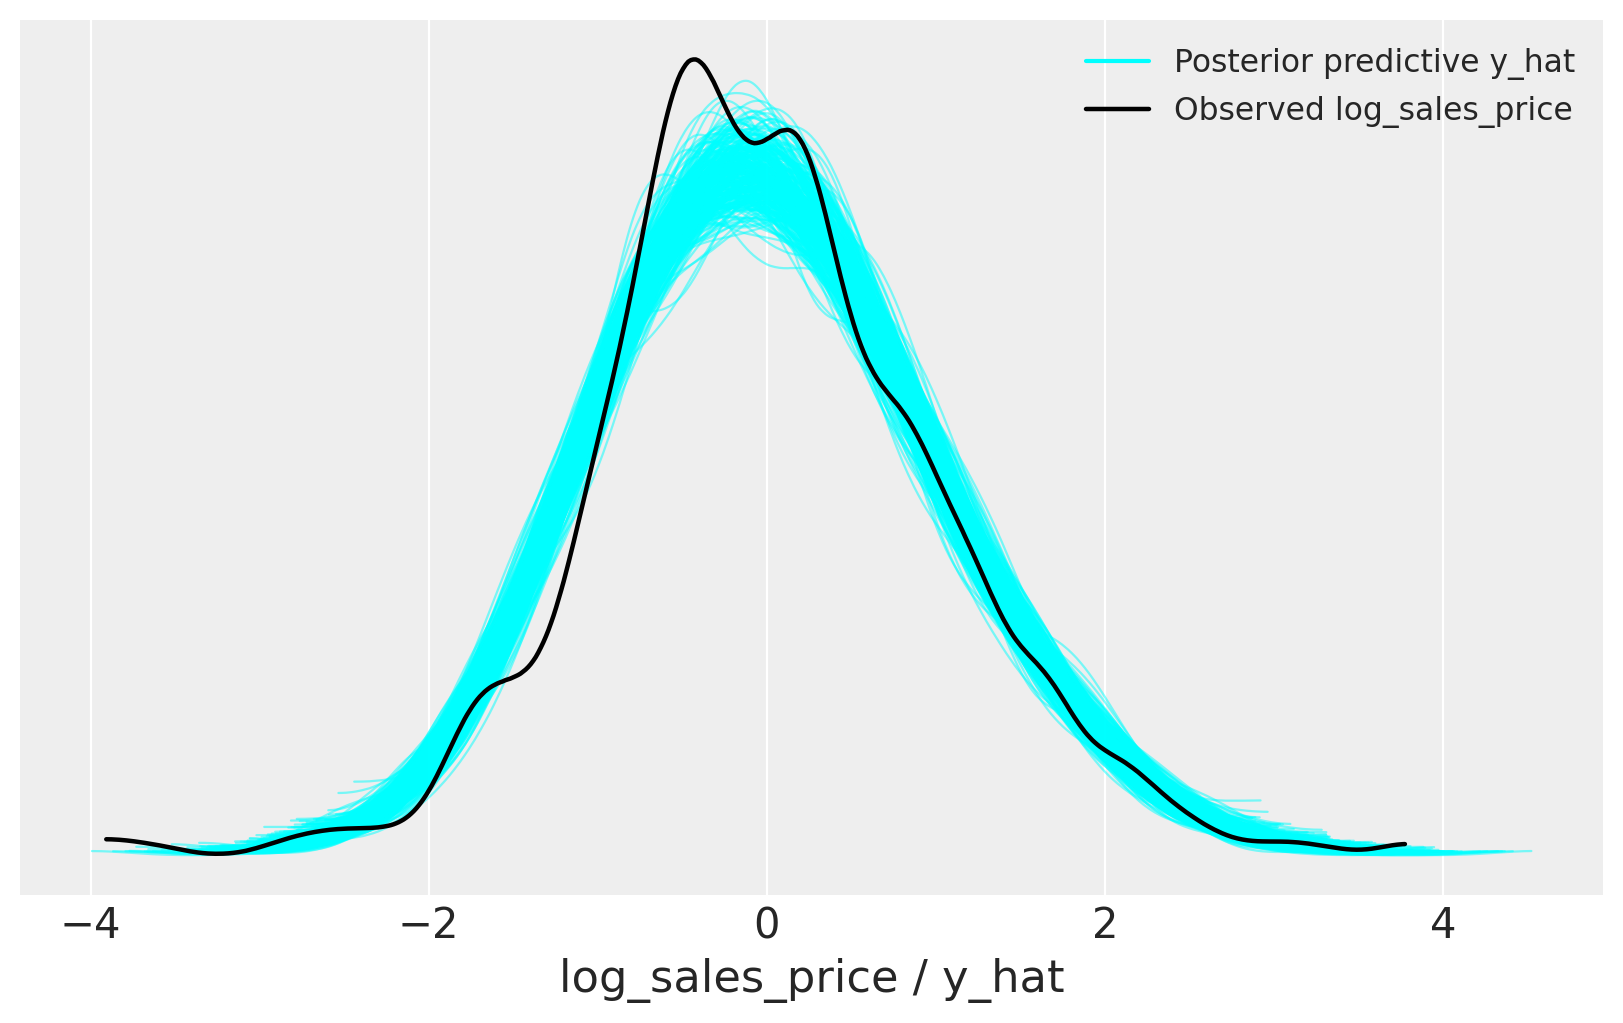

In [115]:
az.plot_ppc(data = npm_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'},
            legend = True,
            color='cyan',
            mean = False,
            figsize=(8, 5),
            alpha = 0.5,
            num_pp_samples=300)

plt.savefig('figures/8_posterior_predictive_check.svg', dpi=72);

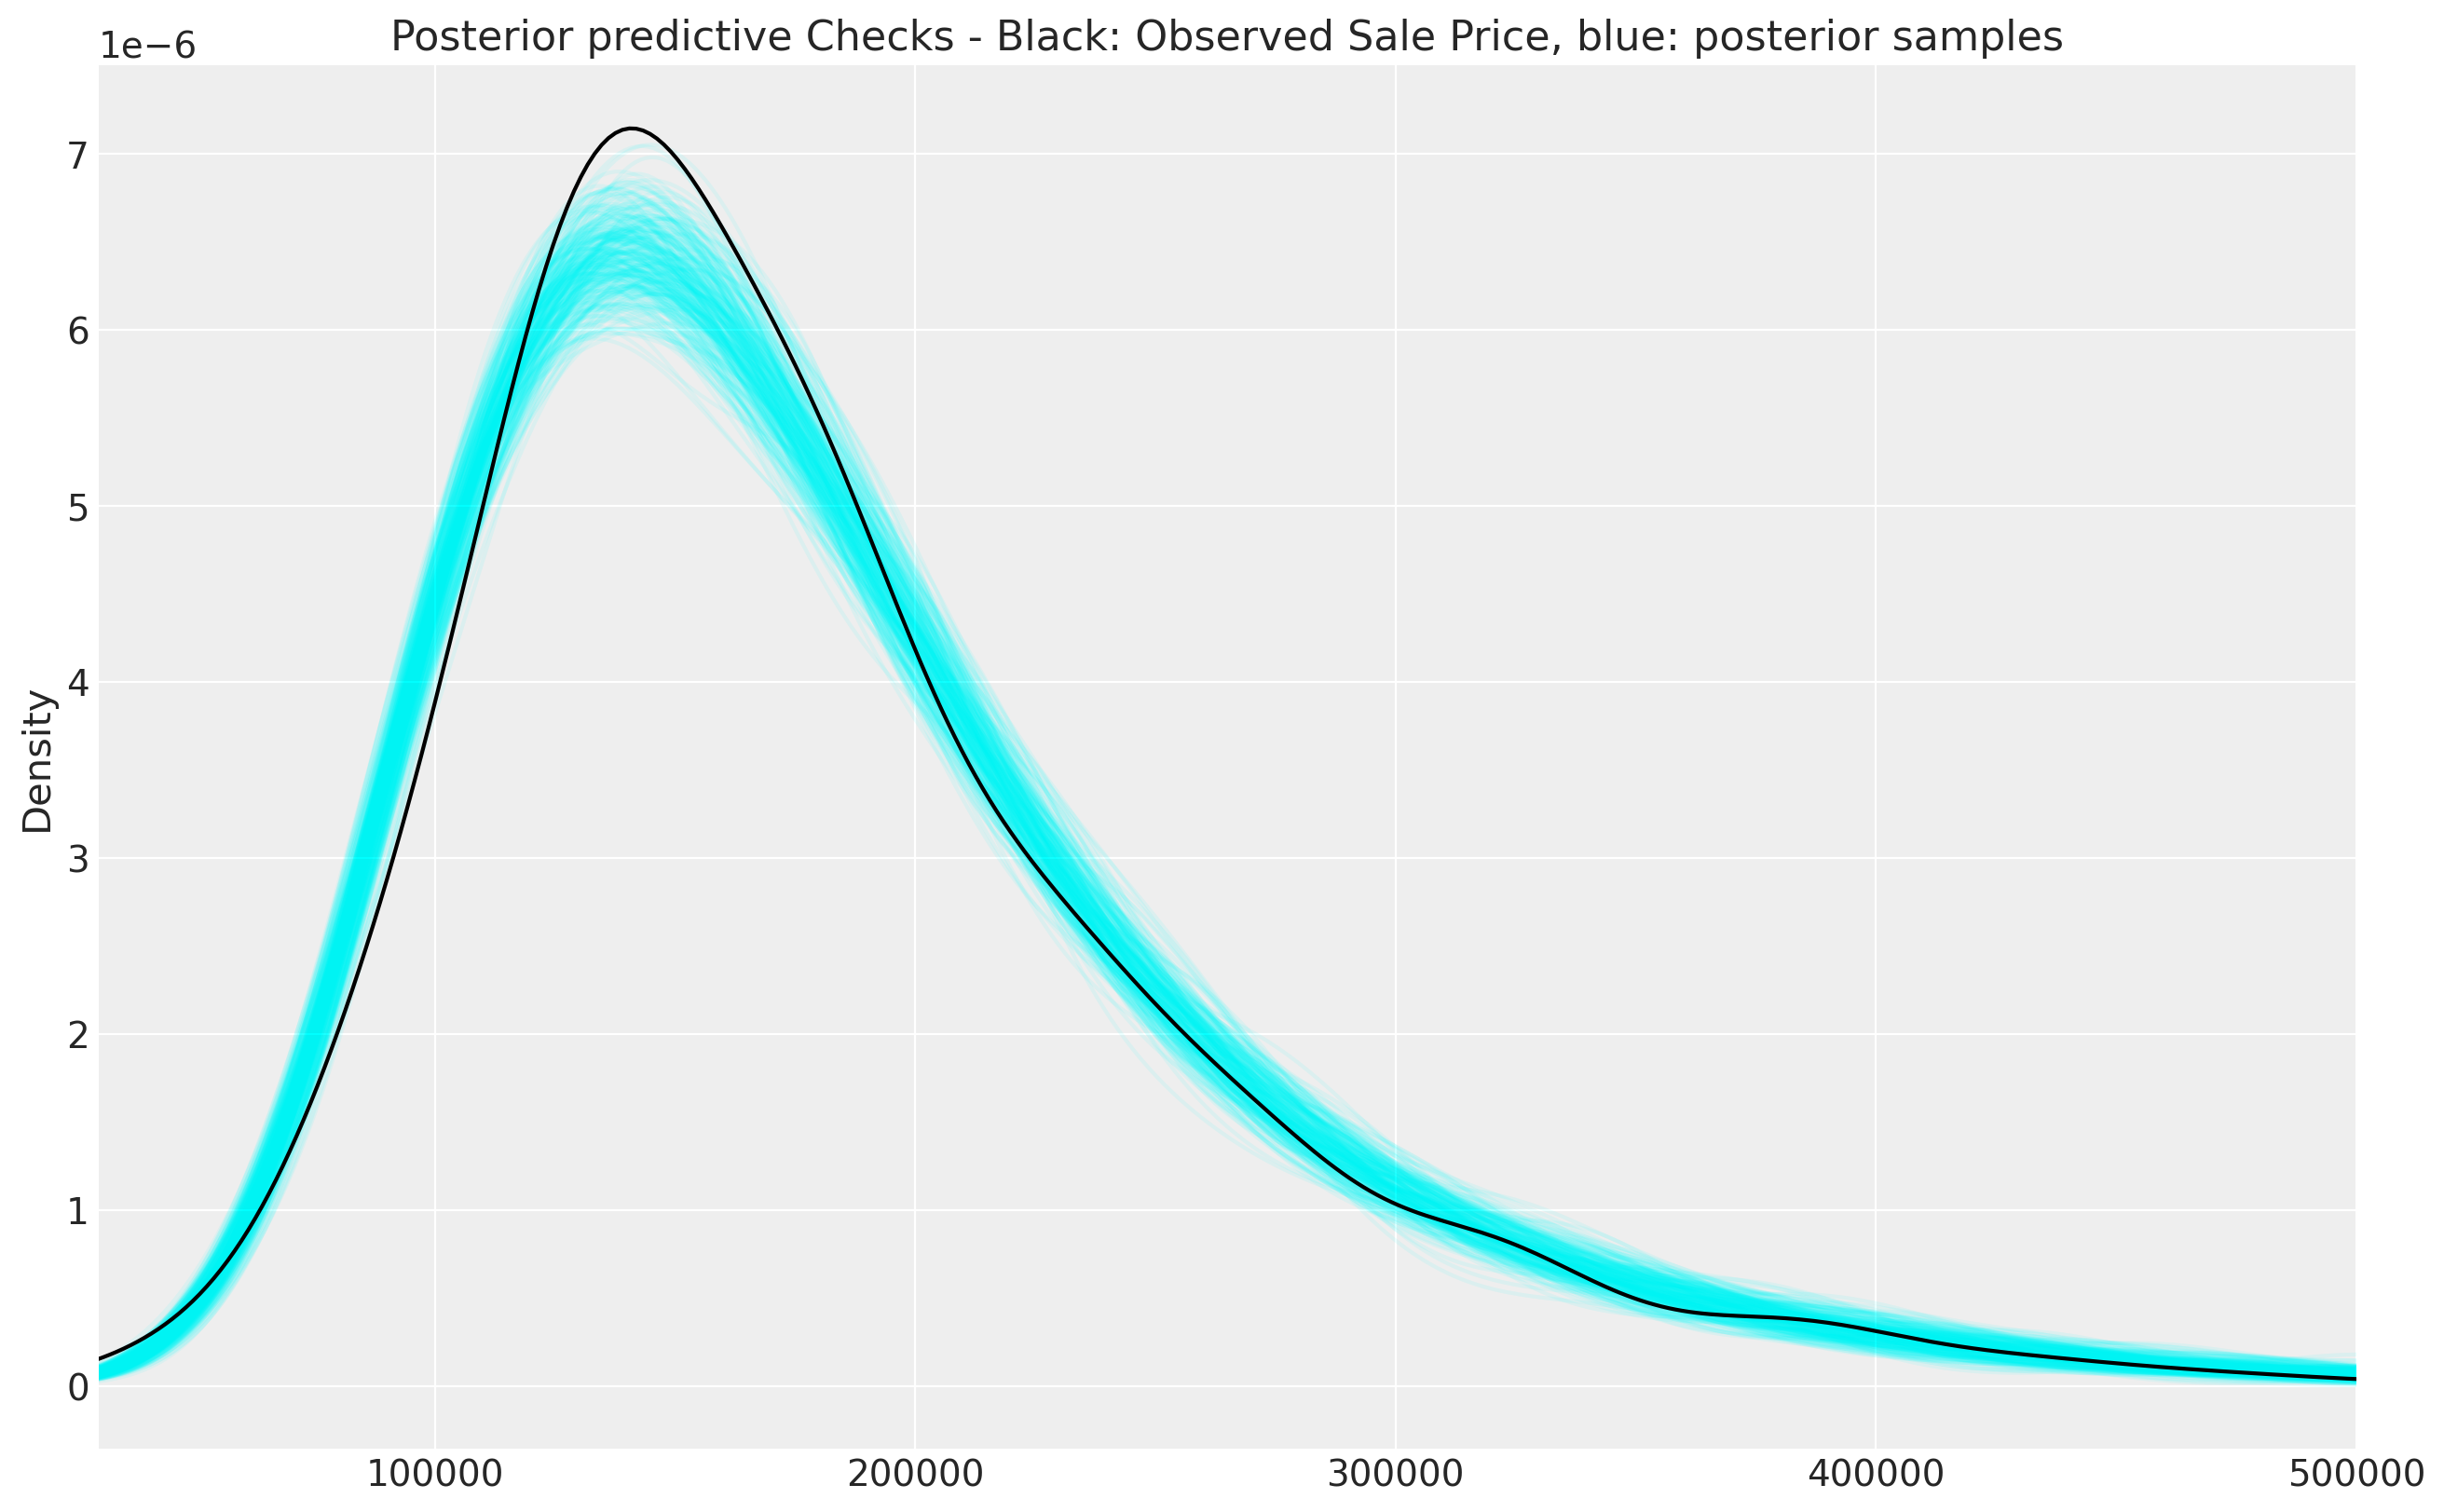

In [116]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_npm_df.filter(regex = 'y_hat')*df['log_sales_price'].std()+df['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predictive Checks - Black: Observed Sale Price, blue: posterior samples', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.08,
                                                                                                  ax = axes, color = 'aqua');

df['SalePrice'].plot.kde(legend = False, 
                         xlim = (30000,500000),
                         alpha = 1,
                         ax = axes,
                         color = 'black');

plt.savefig('figures/9_posterior_predictive_check_outcomescale.svg', dpi=72);

In [ ]:
%load_ext watermark
%watermark -n -v -u -iv -w -a Benjamin_Wee